# 필요한 메세지 외 경고 메세지가 출력되지 않도록함

In [1]:
import warnings
warnings.filterwarnings("ignore")

# 텐서플로 호출

In [2]:
import tensorflow as tf

# tensorflow_datasets 호출

-여기서 우리에게 필요한 여러 종류의 데이터 셋을 받아올 수 있음

In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

꽃 데이터받아오고 (train,varidation,test set)으로 나눔

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%matplotlib inline : 이 화면에 나오게 해라, 이걸 안쓰면 화면에 나오지않음

%config InlineBackend.figure_format = 'retina' : 여기 나올때, 화질을 가장 좋게 해라

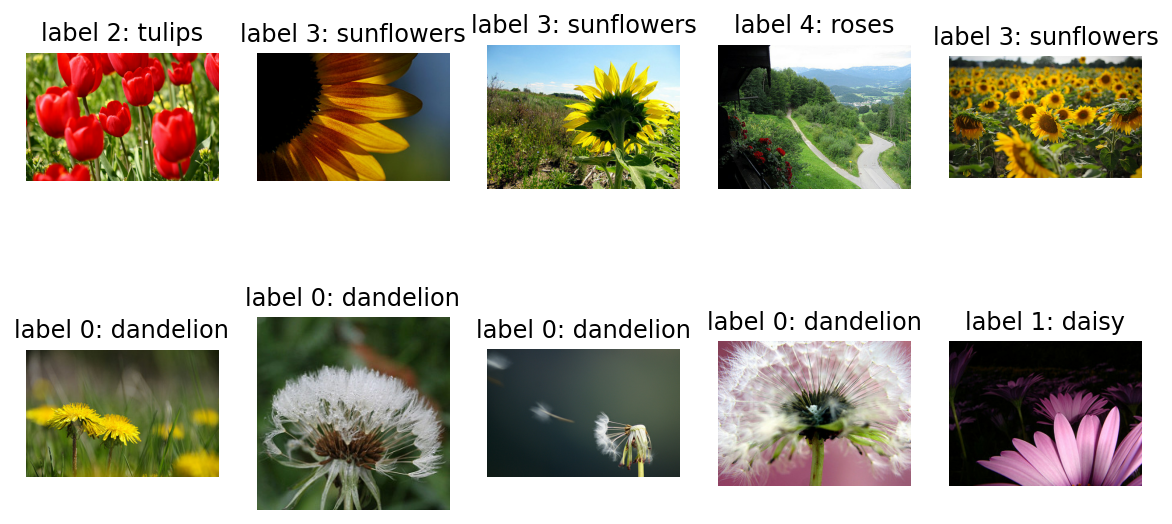

In [7]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

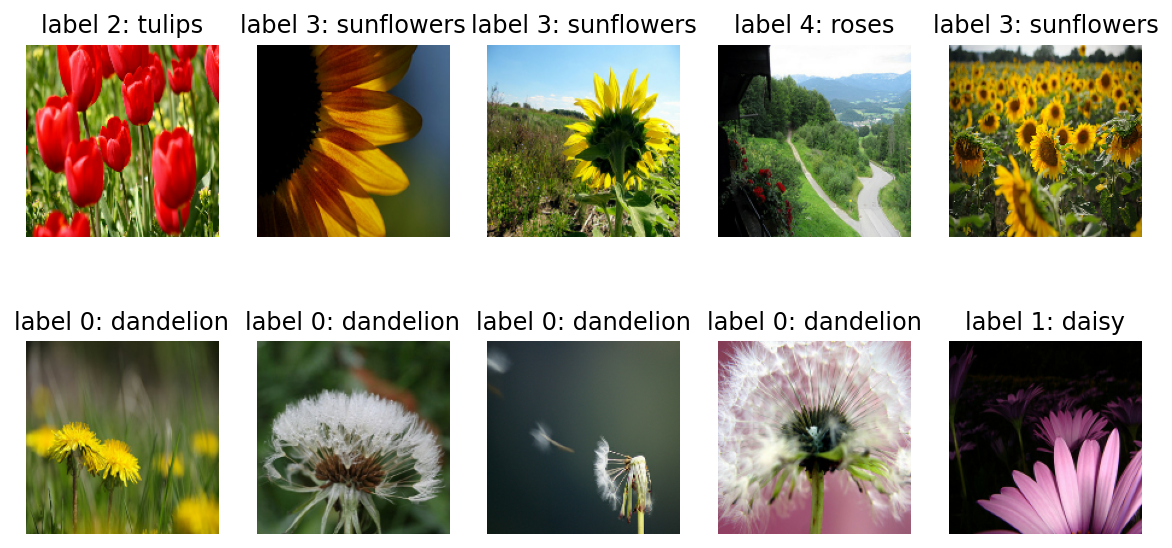

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# VGG16모델을 불러옴
(단, classifier부분은 새로 만들것이므로 이부분을 제외하고 호출한다.)

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

Batch 사이즈 변환해보기 15,32,64

In [14]:
# 전체 3670개의 샘플
BATCH_SIZE = 15
SHUFFLE_BUFFER_SIZE = 500

In [15]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [16]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([15, 160, 160, 3]), TensorShape([15]))

In [17]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([15, 5, 5, 512])

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [19]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(15, 512)


In [20]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')

prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(15, 5)


In [21]:
base_model.trainable = False

In [22]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [25]:
validation_steps=10
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 4s 371ms/step - loss: 1.8012 - accuracy: 0.1600
initial loss: 1.80
initial accuracy: 0.16


In [26]:
EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
196/196 [==============================] - 94s 482ms/step - loss: 1.2652 - accuracy: 0.5831 - val_loss: 1.0005 - val_accuracy: 0.7003
Epoch 2/10
196/196 [==============================] - 94s 478ms/step - loss: 0.8859 - accuracy: 0.7350 - val_loss: 0.7701 - val_accuracy: 0.7221
Epoch 3/10
196/196 [==============================] - 94s 480ms/step - loss: 0.7302 - accuracy: 0.7711 - val_loss: 0.6902 - val_accuracy: 0.7575
Epoch 4/10
196/196 [==============================] - 94s 482ms/step - loss: 0.6508 - accuracy: 0.7878 - val_loss: 0.6176 - val_accuracy: 0.7711
Epoch 5/10
196/196 [==============================] - 96s 488ms/step - loss: 0.5943 - accuracy: 0.8079 - val_loss: 0.5909 - val_accuracy: 0.7793
Epoch 6/10
196/196 [==============================] - 94s 482ms/step - loss: 0.5591 - accuracy: 0.8198 - val_loss: 0.5544 - val_accuracy: 0.8093
Epoch 7/10
196/196 [==============================] - 94s 482ms/step - loss: 0.5268 - accuracy: 0.8277 - val_loss: 0.5386 - val_ac

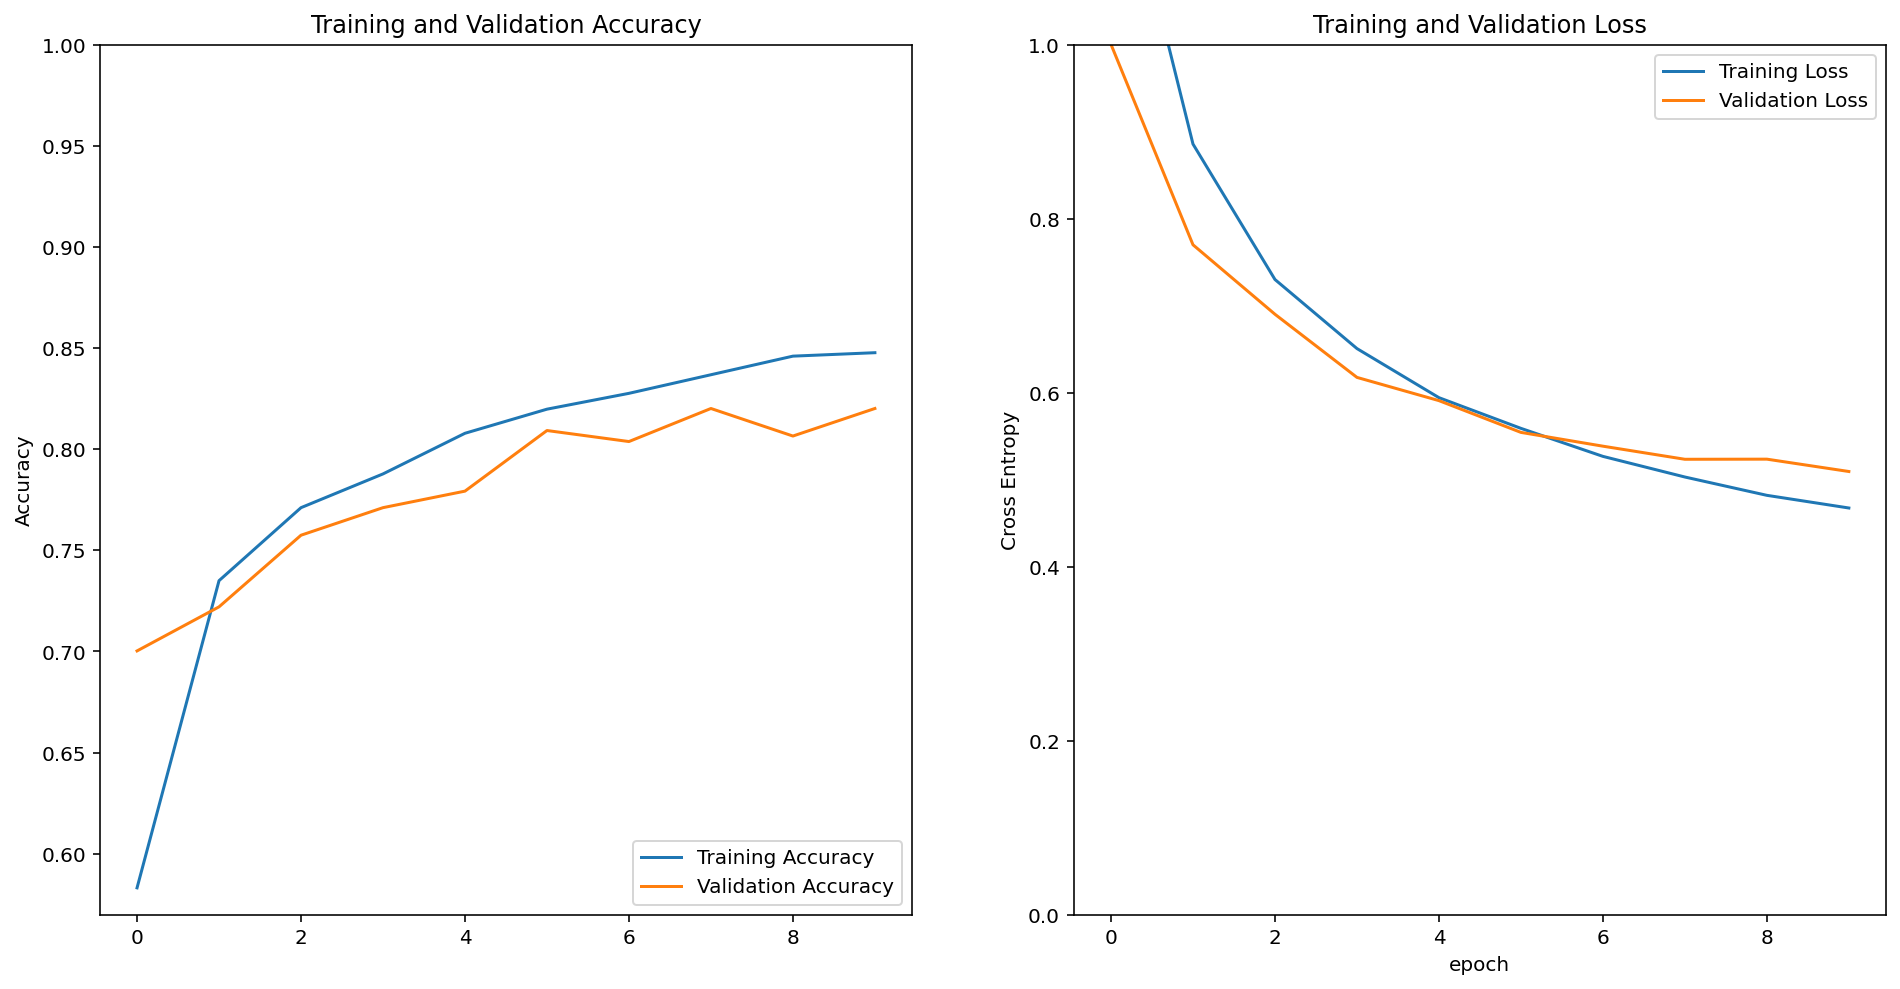

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.09310867e-02, 5.79540394e-02, 7.48547792e-01, 4.31076139e-02,
        1.39459535e-01],
       [9.99497771e-01, 4.23820777e-04, 3.39056282e-06, 4.42163291e-05,
        3.08748895e-05],
       [7.43955553e-01, 1.08196989e-01, 1.64514706e-02, 1.13559082e-01,
        1.78367868e-02],
       [2.34626629e-03, 9.49938875e-03, 6.10204756e-01, 6.66101417e-03,
        3.71288657e-01],
       [6.59751236e-01, 2.88765609e-01, 1.18190851e-02, 1.88902766e-02,
        2.07738429e-02],
       [9.33374047e-01, 3.67821716e-02, 3.67203611e-03, 2.51957681e-02,
        9.75939096e-04],
       [8.05571023e-03, 9.81418137e-03, 7.89281607e-01, 1.53067082e-01,
        3.97814214e-02],
       [3.49963665e-01, 4.76326942e-01, 8.94937140e-04, 1.69744745e-01,
        3.06968647e-03],
       [6.63923193e-03, 1.27177325e-03, 1.46109983e-02, 9.27718103e-01,
        4.97598574e-02],
       [9.99629378e-01, 3.12167511e-04, 5.27347595e-07, 5.70090015e-05,
        9.88140528e-07],
       [9.71834600e-01, 2.3079

In [36]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0])

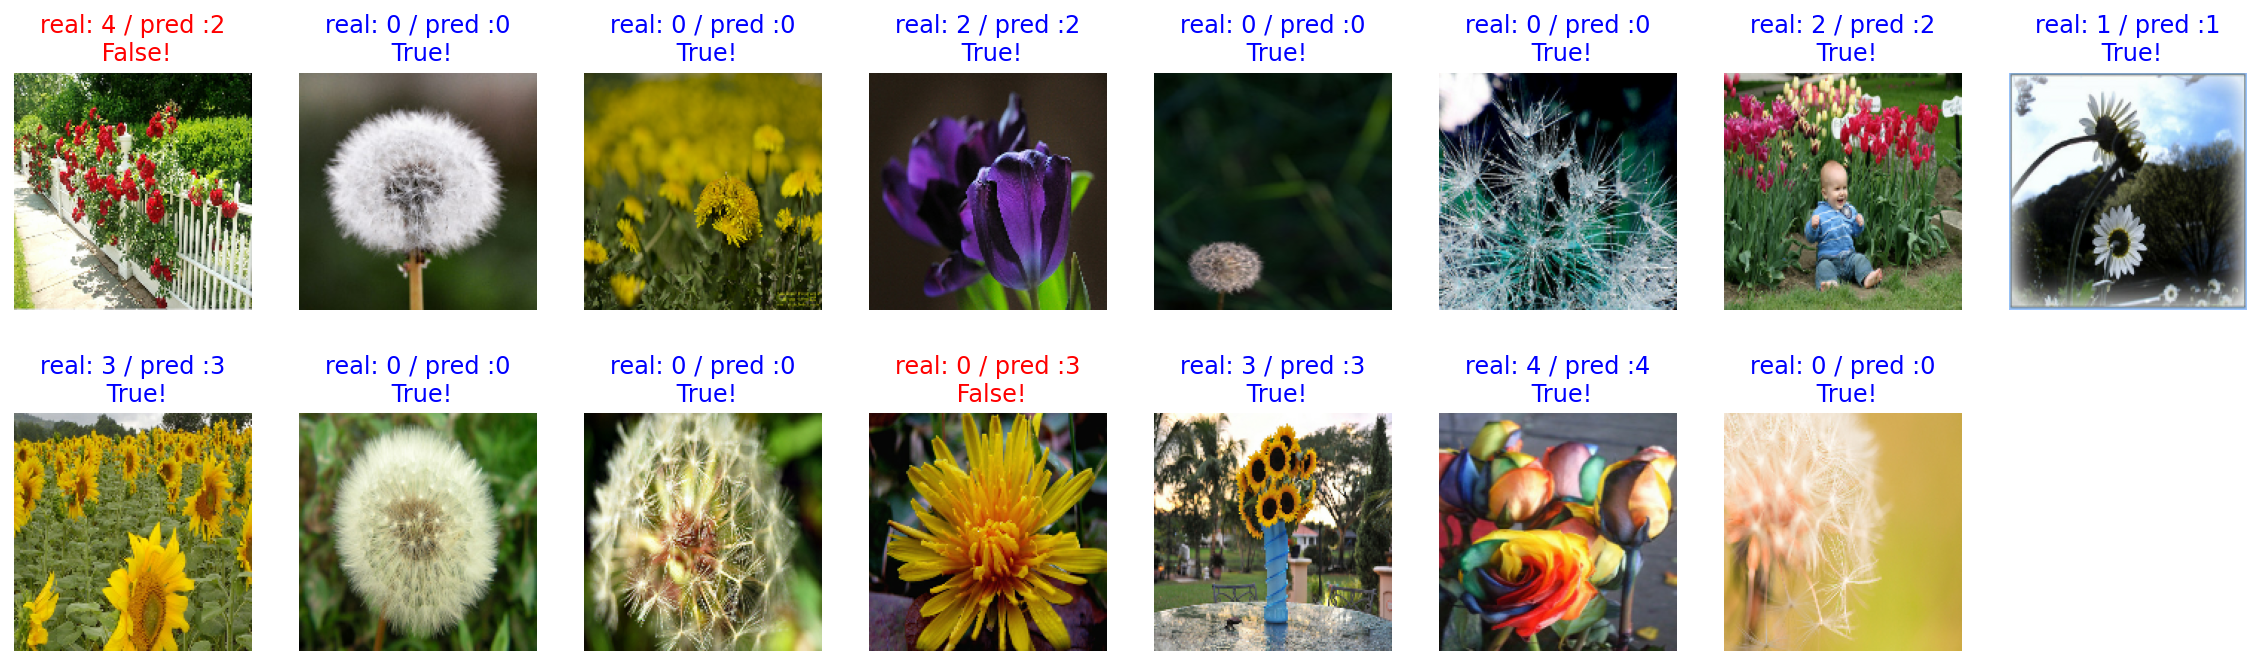

In [37]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

# Test set을 통한 정확도 확인

In [38]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 15 * 100)

86.66666666666667


# checkpoint 생성

In [39]:
import os
checkpoint_dir = os.getenv("HOME") + "/aiffel/tf_flowers/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
 os.mkdir('checkpoint_dir') 

model.save_weights(checkpoint_file_path) 
# checkpoint 파일 생성
if os.path.exists(checkpoint_file_path): 
	print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [40]:
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers/images"
os.path.exists(img_dir_path)

True

In [41]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 5가지 꽃 분류기에 대한 함수만들기

In [44]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulip_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    rose_percentage = round(prediction[4] * 100)
    print(f"This image seems {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulip_percentage}% tulip, {sunflower_percentage}% sunflower, and {rose_percentage}% rose.")

# 고흐의 해바라기 그림을 통한 결과 확인

This image seems 0% dandelion, 0% daisy, 0% tulip, 100% sunflower, and 0% rose.


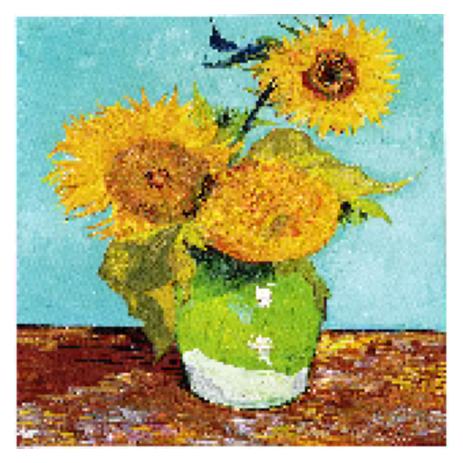

In [45]:
filename = 'Vincent_Van_Gogh_Sunflowers.jpg'

show_and_predict_image(img_dir_path, filename)

# 결과 및 원인 분석

VGG16 model을 활용하여 Trasfer learning을 진행하였다.

tf_flowers의 데이터 셋이 상당히 적었기 때문에 VGG16의 convolutional base는 그대로 사용하고 classifier만 새로 만들어 사용하는 방식을 택하였다.

model을 학습시키는 과정에 있어서 여러가지 요소를 조절해 볼 수 있었다.
1. base model
2. optimizer
3. size of batch
4. size of input data(pixel size)
5. number of EPOCH

여러 가지 요소를 조절 해 보았고 test set에서 86.7%의 정확도를 얻을수 있었다. 